Interactive version of the tutorial: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pgrigorev/ModMatEcole/HEAD?labpath=tutorials%2FT1_1_python_ecosystem.ipynb)

# Introduction to python

![](https://imgs.xkcd.com/comics/python.png)

The main advantage of using python is that it gives access to a plethora of scientific and data analysis tools. You can look [here](https://learnpython.org/) for interactive examples on basic python syntax. In this tutorial we will use following _packages_:
- [numpy](https://numpy.org/doc/stable/user/whatisnumpy.html) for efficient handling of arrays
- [pandas](https://pandas.pydata.org/) for data manipulation and import/export. 
- [matplotlib](https://matplotlib.org/stable/), [Bokeh](https://bokeh.org/), [Plotly](https://plotly.com/) for (interactive) data visulisation
- [Atomic simulation environment](https://wiki.fysik.dtu.dk/ase/) for working with atomistic systems
- [scikit-learn](https://scikit-learn.org/stable/) for machine learning

Most of these packages have detailed documentation and tutorials, feel free to click the links and explore. 

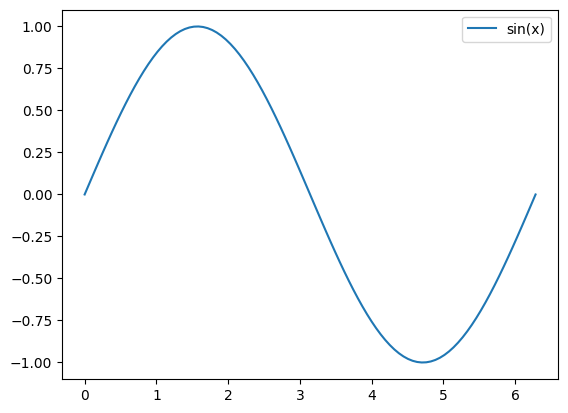

In [4]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

fig, ax = plt.subplots()
ax.plot(x, y, label='sin(x)')
ax.legend()
plt.show()



In [9]:
import plotly.express as px

fig = px.line(x=x, y=y, labels={'x':'x', 'y':'sin(x)'}, width=800, height=500)
fig.show()

In [12]:
import bokeh.plotting as bp
from bokeh.io import output_notebook
output_notebook()

p = bp.figure(width=800, height=500)
p.line(x, y, legend_label='sin(x)')

bp.show(p)

Loading BokehJS ...

# Atomistic simulations

We will use [NGLViewer](http://nglviewer.org/ngl/api/index.html) for interactive visualisation of atomic cells in the notebooks. You can use your mouse to:
- Translation: right click + drag
- Rotation: left click + drag
- Z-axis rotation: Ctrl + right click + drag
- Zoom: scroll wheel
- Center view: left click on the desired atom (or its representation)

You can also represent distances by following this procedure:
- Right click on a single atom. You will see a green sphere wrapping it.
- Double right click on another atom. You will see a dashed line between the two atoms, along with the reported distance in Å.
To remove a distance representation, repeat the sequence on the same atoms.

[Open visualisation tool OVITO](https://www.ovito.org/) can be used to look at atomic configurations. One can use `ase.io.write()` function to save the configuration as `.xyz` file and import it to OVITO. The advantage is that OVITO has a number of analysis tools.

Lets have a look on FCC Ni atomic cell.

In [88]:
from ase.lattice.cubic import FaceCenteredCubic
from helper_functions import show_structure


atoms = FaceCenteredCubic('Fe', latticeconstant=3.6)
print(f"Unit cell contains {len(atoms)} atoms") 
show_structure(atoms)


Unit cell contains 4 atoms


NGLWidget()

we can enlarge the cell by simply repeating it in three directions:

In [89]:
larger_atoms = atoms * (2, 3, 10)
show_structure(larger_atoms)
from ase.calculators.lj import LennardJones
from ase.units import kcal, mol
LJ_calc = LennardJones(epsilon=6.0 * (kcal / mol), sigma=2.31)

NGLWidget()

In [279]:
atoms = FaceCenteredCubic('Fe', latticeconstant=3.6)
atoms.calc = LJ_calc
atoms.get_potential_energy()

-8.243347678204163

In [280]:
atoms.get_forces()

array([[-3.38271078e-17, -1.86482774e-17,  5.63785130e-18],
       [-4.77048956e-17, -8.73866951e-17, -2.21177243e-17],
       [-6.72205347e-17, -9.75781955e-18, -7.48099499e-17],
       [ 3.27429056e-17, -1.30321101e-16, -6.41847686e-17]])

Lattice constant: 3.5722 Å


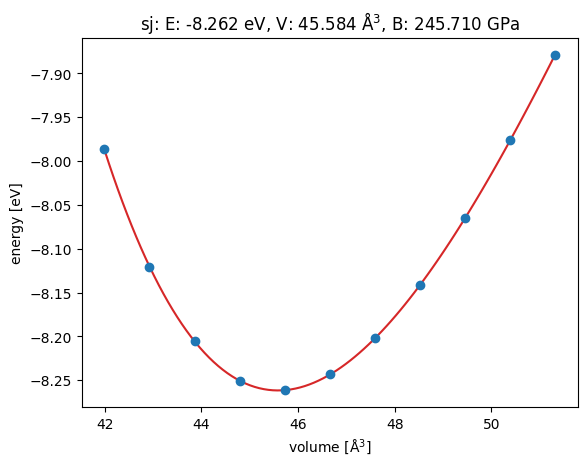

In [291]:
from ase.eos import calculate_eos
eos = calculate_eos(atoms, npoints=11, eps=0.1)
eos.plot()

print(f'Lattice constant: {eos.v0 ** (1/3):.4f} Å')

## Interstitial and vacancy formation energies

## Vacancy migration barrier